In [2]:
from sklearn import mixture
import json
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pylab as plt
import statsmodels.formula.api as smf
import os
s = json.load(open(os.getenv('PUI2015')+'/nk1877.json'));
plt.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


# Training Dataset Analysis

In [2]:
#Reading training data
train=pd.read_csv('train')

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
train.columns

Index([u'id', u'click', u'hour', u'C1', u'banner_pos', u'site_id',
       u'site_domain', u'site_category', u'app_id', u'app_domain',
       u'app_category', u'device_id', u'device_ip', u'device_model',
       u'device_type', u'device_conn_type', u'C14', u'C15', u'C16', u'C17',
       u'C18', u'C19', u'C20', u'C21'],
      dtype='object')

In [8]:
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79


In [8]:
train.describe()

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000,40428967.000000
mean,0.169806,14102558.253986,1004.967834,0.288015,1.015305,0.331315,18841.805451,318.883117,60.102009,2112.601188,1.432499,227.144378,53216.848336,83.382288
std,0.375462,296.683723,1.094586,0.506382,0.527434,0.854794,4959.456696,21.272501,47.295382,609.412397,1.326227,351.022128,49956.815409,70.289962
min,0.000000,14102100.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,0.000000,14102304.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,0.000000,14102602.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000
75%,0.000000,14102814.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100093.000000,101.000000
max,1.000000,14103023.000000,1012.000000,7.000000,5.000000,5.000000,24052.000000,1024.000000,1024.000000,2758.000000,3.000000,1959.000000,100248.000000,255.000000


In [253]:
## Checking for null values
k=[]
for i in train.columns:
    if train[pd.isnull(train['click'])].shape[0]>0:
        train[pd.isnull(train['click'])].shape[0]
    else:
        k.append("No null Values")
print(list(set(k))[0])

No null Values


In [9]:
# Calculating ration of click rate to not clicked rate.
train.click.value_counts()[1]*1.0/train.click.value_counts()[0]

0.20453719011982546

In [10]:
train.shape

(40428967, 24)

In [11]:
#Calculating click ration
train.click.value_counts()[1]*1.0/train.shape[0]

0.16980562476404604

### Observation
So, we know data has more than 40 million rows and click ratio is 16.98%. Quick look at the description suggests data is clean, however we don't know if there is any error or any other kind on inconsistency in the data set. 27 predictors are decent sized feature for individual feature analyis at exploratory phase.

In [9]:
# Time is converted to provide day hour and weekdays. Months and year won't play any role for this analysis as data is
#from same month and year.
train['date']=pd.to_datetime(train.hour,format='%y%M%d%H')
train['day']=train.date.dt.day
train['hour']=train.date.dt.hour
train['weekday']=train.date.dt.weekday

# 1. Time based Visualization for training data

### 1.1 Distribution for overall activity

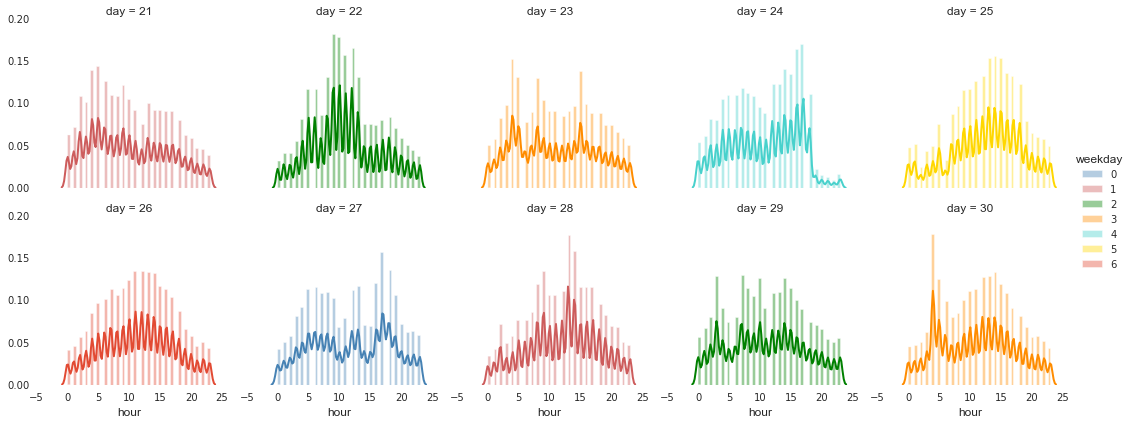

In [227]:
g = sns.FacetGrid(train, col='day',col_wrap=5,hue='weekday')
g.map(sns.distplot, "hour")
g.add_legend();

In [53]:
## Data is grouped by day to visualize click count for each day
dates=train.groupby(train.date.dt.day)
datesdf=dates.sum()
datesdf=datesdf.reset_index()

### 1.2a Total click count based on day of week and hour (Complete Training Data)

([<matplotlib.axis.XTick at 0x10ff47410>,
 <a list of 7 Text xticklabel objects>)

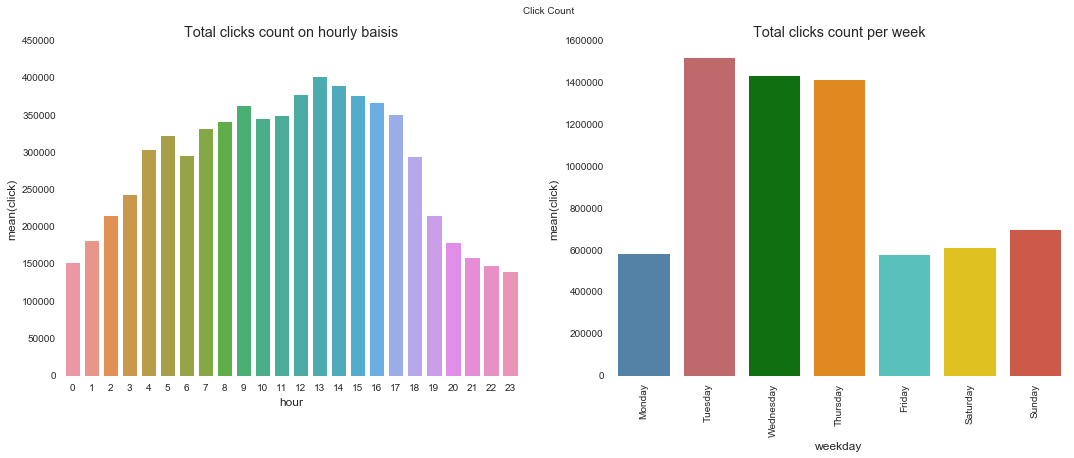

In [13]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig,ax= plt.subplots(figsize=(18,6),ncols=2,nrows=1)
d_hour=train.groupby('hour').sum()
d_hour=d_hour.reset_index()
sns.barplot(x="hour", y="click", data=d_hour,ax=ax[0]);
ax[0].set_title('Total clicks count on hourly baisis')
d_weekday=train.groupby('weekday').sum()
d_weekday=d_weekday.reset_index()
sns.barplot(x="weekday", y="click", data=d_weekday,ax=ax[1]);
ax[1].set_title('Total clicks count per week')
plt.suptitle("Click Count")
plt.xticks(range(7),weekdays,rotation=90)

### 1.2b Total click rate based on day of week and hour (Complete Training Data)

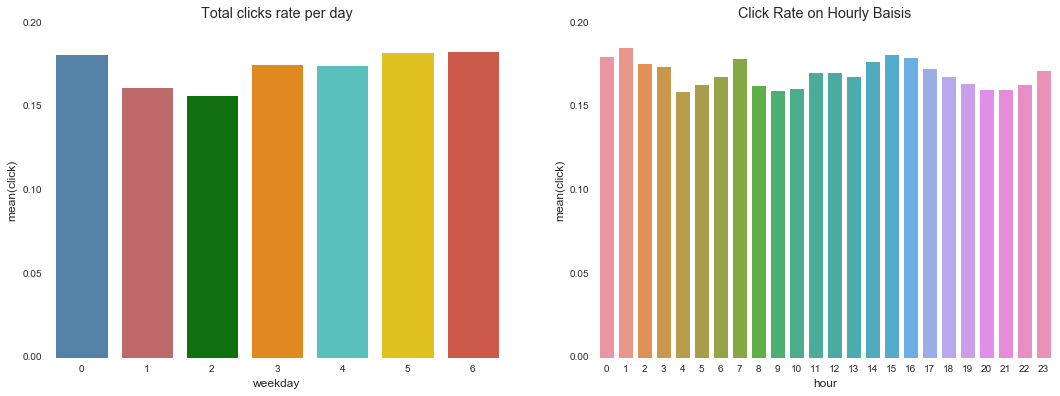

In [10]:
fig,ax= plt.subplots(figsize=(18,6),ncols=2,nrows=1)
weeklyrate= train.groupby('weekday').sum()[['click']]/train.groupby('weekday').count()[['click']]
weeklyrate=weeklyrate.reset_index()
sns.barplot(x='weekday', y='click',data=weeklyrate,ax=ax[0]);
ax[0].set_title('Total clicks rate per day')
hourlyratet=train.groupby('hour').sum()[['click']]/train.groupby('hour').count()[['click']]
hourlyratet=hourlyratet.reset_index()
sns.barplot(x='hour',y='click',data=hourlyratet,ax=ax[1])
ax[1].set_title("Click Rate on Hourly Baisis")

# Sample Analysis

In [3]:
#choosig 1% dataset for analysis would give 404,289 rows. This should be sufficient for analysis.
s=round(40428967*(1.0/100))

In [4]:
# Setting a seed and selecting sample
sampletrain=train.sample(n=s,random_state=777)

In [5]:
sampletrain['date']=pd.to_datetime(sampletrain.hour,format='%y%M%d%H')
sampletrain['day']=sampletrain.date.dt.day
sampletrain['hour']=sampletrain.date.dt.hour
sampletrain['weekday']=sampletrain.date.dt.weekday

In [18]:
##Checking sample's mean and standard deviation and comparing it with original dataset to make sure that sample dataset
## provides same distripution as original data
sampletrain.describe()

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day,weekday
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.00000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.170039,11.266336,1004.969131,0.288182,1.015828,0.330960,18839.177892,318.875362,60.093349,2112.23337,1.429236,226.501944,53172.406965,83.393240,25.470350,2.602738
std,0.375667,5.960399,1.099077,0.504705,0.529633,0.853916,4953.149587,21.246820,47.136613,608.84324,1.325859,351.240866,49959.717698,70.281435,2.965089,1.727236
min,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.00000,0.000000,33.000000,-1.000000,1.000000,21.000000,0.000000
25%,0.000000,6.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.00000,0.000000,35.000000,-1.000000,23.000000,23.000000,1.000000
50%,0.000000,11.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.00000,2.000000,39.000000,100048.000000,61.000000,26.000000,2.000000
75%,0.000000,16.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.00000,3.000000,171.000000,100088.000000,101.000000,28.000000,4.000000
max,1.000000,23.000000,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.00000,3.000000,1839.000000,100248.000000,255.000000,30.000000,6.000000


Sample set have almost same distribution as the original training data set. It could be compared using mean and standard deviation for all the distributions in the data set. Therefore it could be assumend that the sample could represent the training set.

I would start by visualizing the datasets and finding impact of various features on each other. This would be useful for hypothesis testing to deduce if there is any relationship between different features.

# 2. Time Based Visualization

In [556]:
# This dataset also maintains the same click ratio as original training data
sampletrain.click.value_counts()[1]*1.0/sampletrain.shape[0]

0.16903254849872246

### 2.1 Distribution plot of the sample based on clicks

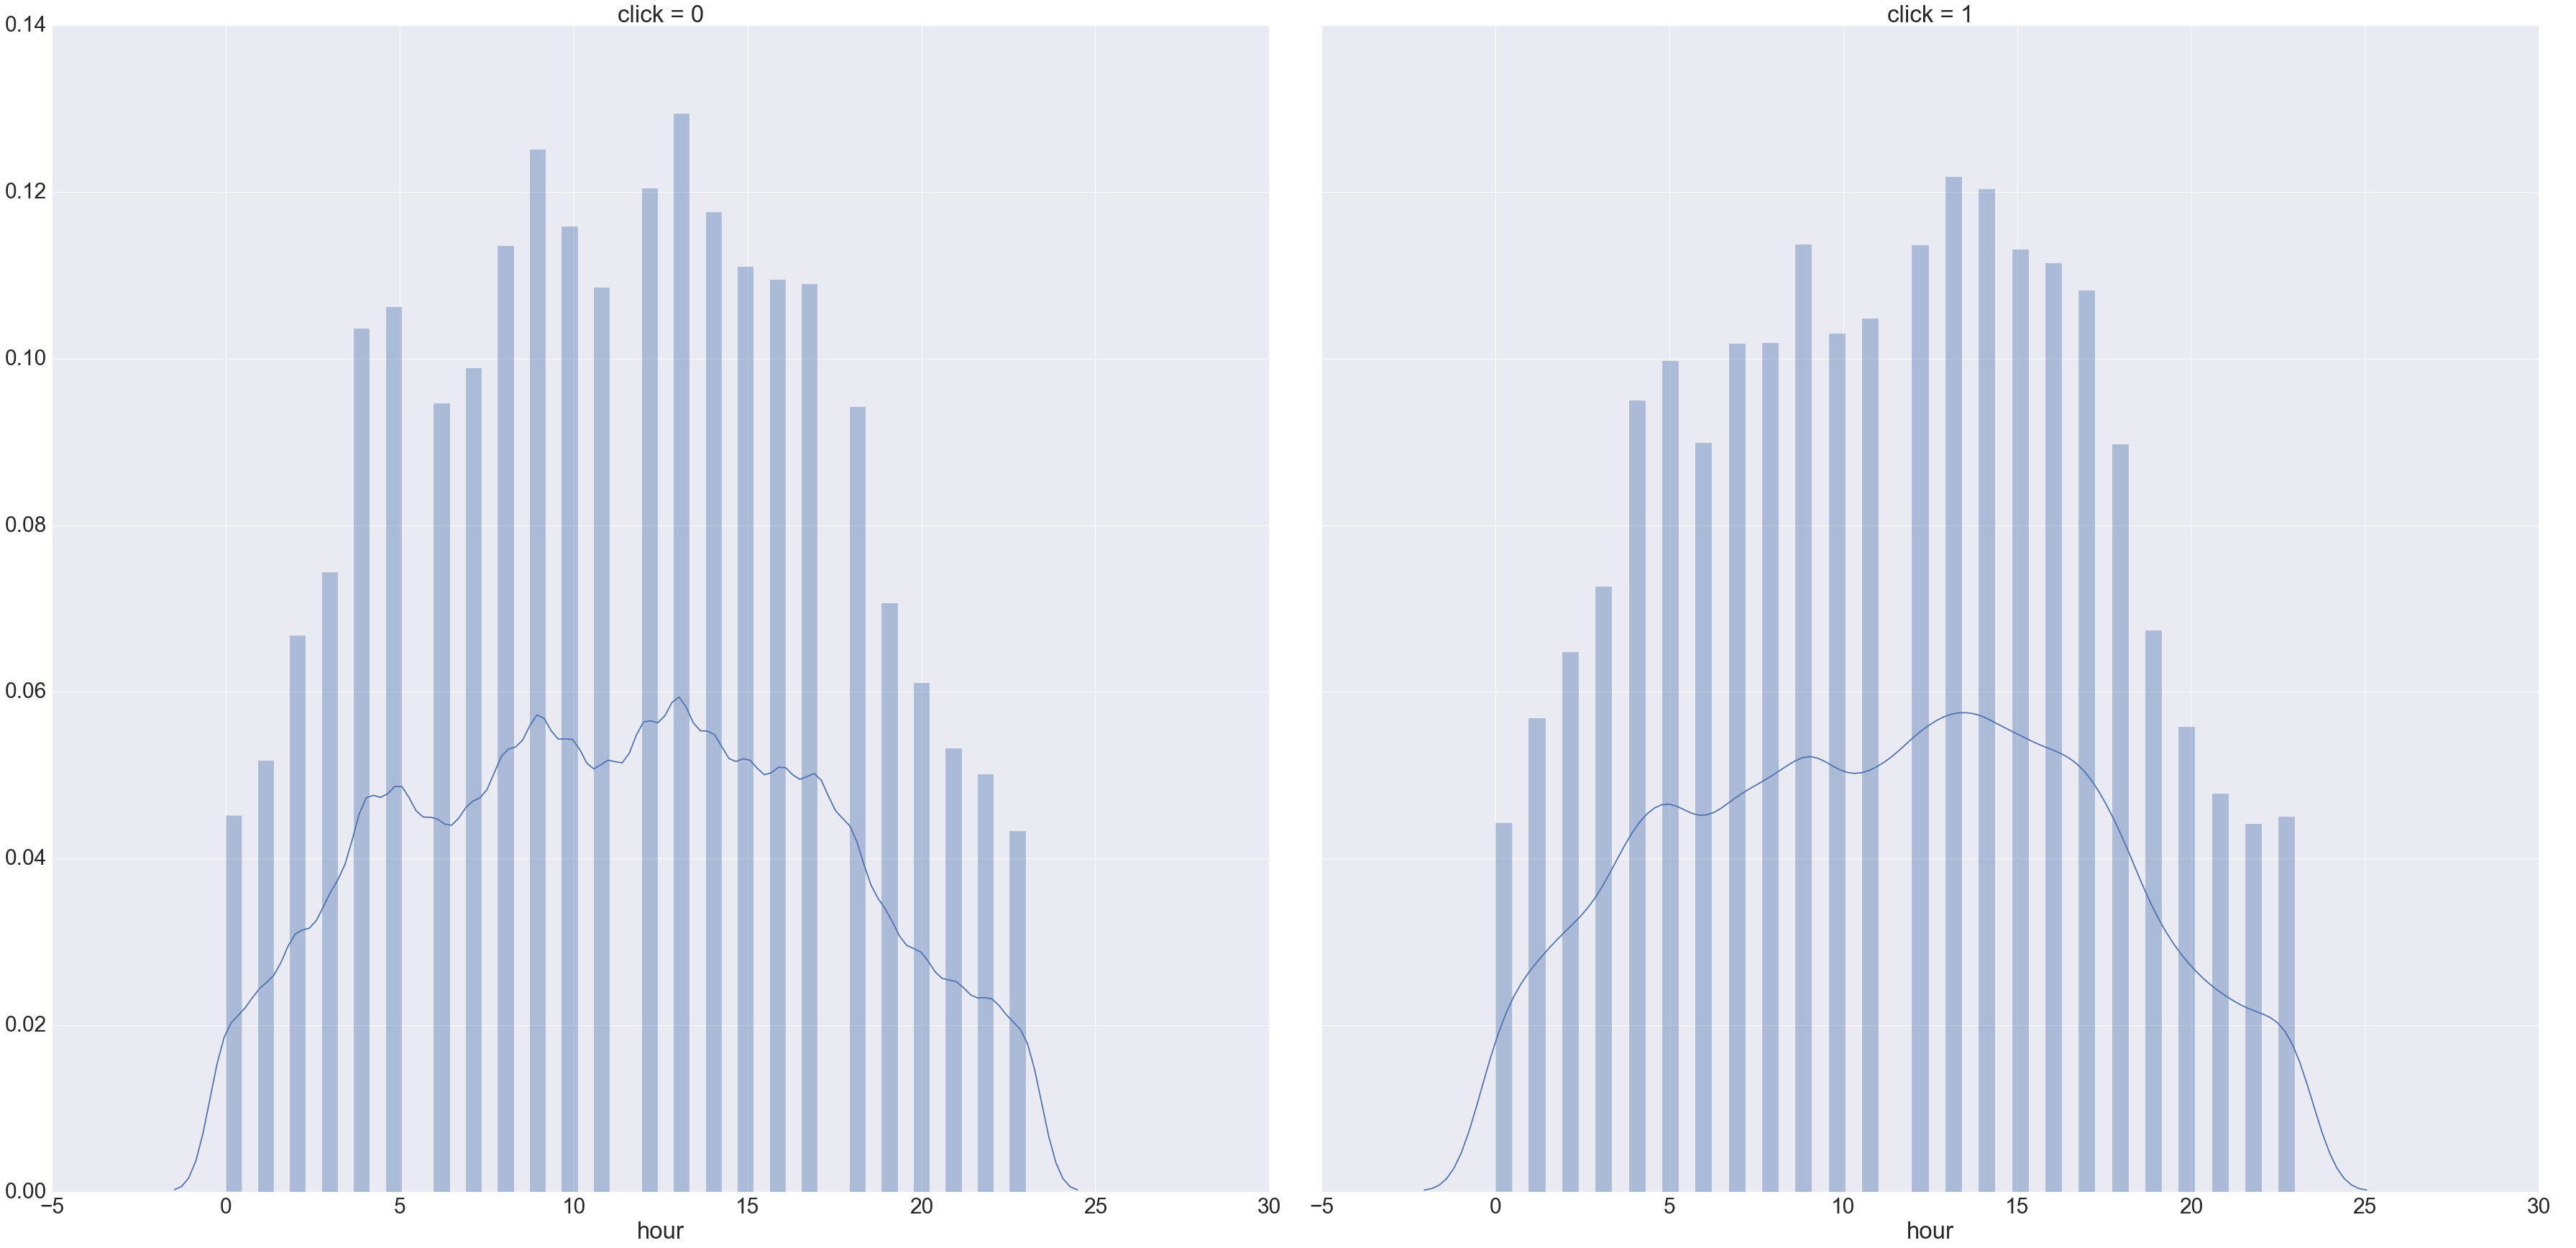

In [279]:
sns.set(font_scale=3)
g = sns.FacetGrid(sampletrain, col='click',size=25)
g.map(sns.distplot, "hour")
g.add_legend();

* Note: Data is scaled to be between 0 and 1 having area under curve of 1 unit
### Observation:
Here just looking at distribution of clicks and non clicks. Appears Overeall click distribution is same. This suggests people visits website at same intervals of time but clearly at we know only 16% clicks the advert.

### 2.2a no clicks count distribution for each day from 1% sample

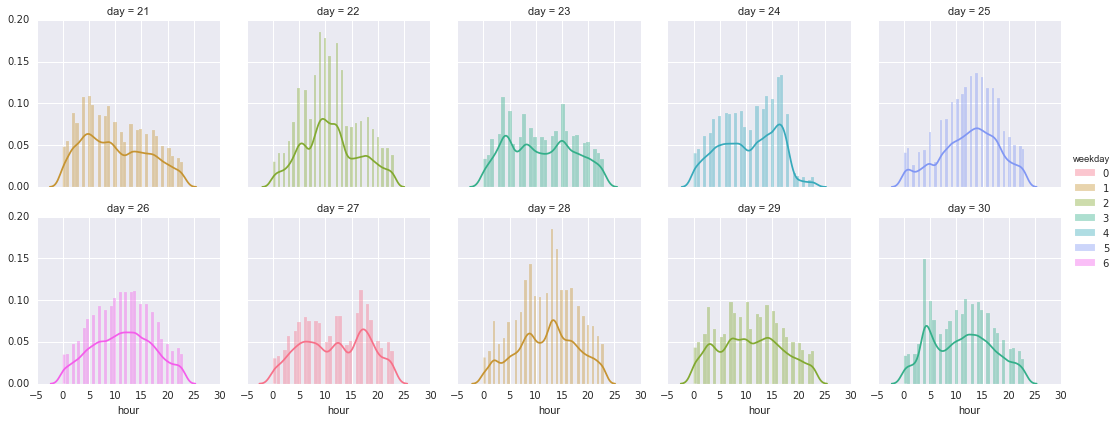

In [315]:
g = sns.FacetGrid(sampletrain[sampletrain.click==0], col='day',col_wrap=5,hue='weekday')
g.map(sns.distplot, "hour")
g.add_legend();

* Note: Y axis is density values scales such that area under curve comes out be 1

### 2.2b click count distribution based on hours on 1% sample

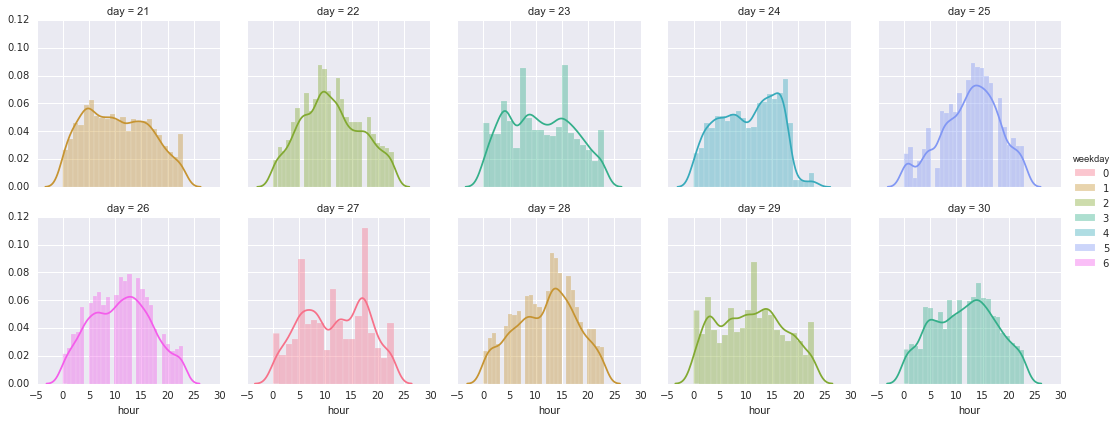

In [278]:
sns.set(font_scale=1)
g = sns.FacetGrid(sampletrain[sampletrain.click==1], col='day',col_wrap=5,hue='weekday')
g.map(sns.distplot, "hour")
g.add_legend();

### Observation

Distribution for each day is similar for click count and non click count. But all days have higher peak in not click plot(2.2a) when compared to click plot at 2.2b. This clearly indicates higher non click compared to clicks on all days. 

We can also verify distribution by plotting box plots, which tells more about the distribution pattern on hourly baisis.

### 2.2c Boxplot distribution for no clicks and click count for each day on hourly basis

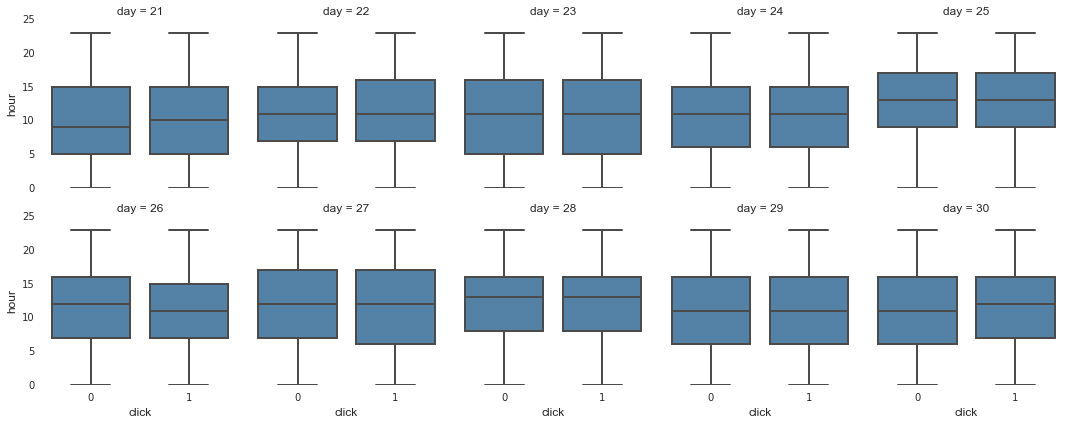

In [201]:
g = sns.FacetGrid(sampletrain, col='day',col_wrap=5)
g.map(sns.boxplot, "click",'hour')
g.add_legend();

### Observation
Distribution of clicks and non clicks is approximately same in 24 hour scale. Although using the given informaton of 1.5 weeks it is hard to acertain weekly patterns.

General distribution suggests most online activity happens somewhere between 8 AM to 4PM inrrespective of the fact whether user clicks or not.

### 2.3a Visualizing click rate on hourly and daily baisis for sample data

In [393]:
#Calculating hourly click rate
counthourly=sampletrain.groupby(sampletrain['hour']).count().reset_index().click
clickhourly=sampletrain.groupby(sampletrain['hour']).sum().reset_index().click
## click per hour/ total click activity in each hour
rate=clickhourly*1.0/counthourly

In [663]:
## Caclulating daily click rate
countdaily=sampletrain.groupby(sampletrain['weekday']).count().reset_index().click
clickdaily=sampletrain.groupby(sampletrain['weekday']).sum().reset_index().click
## click per day/ total click activity in each day
ratedaily=clickdaily*1.0/countdaily

In [666]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',]

([<matplotlib.axis.XTick at 0x38bfc2dd0>,
 <a list of 7 Text xticklabel objects>)

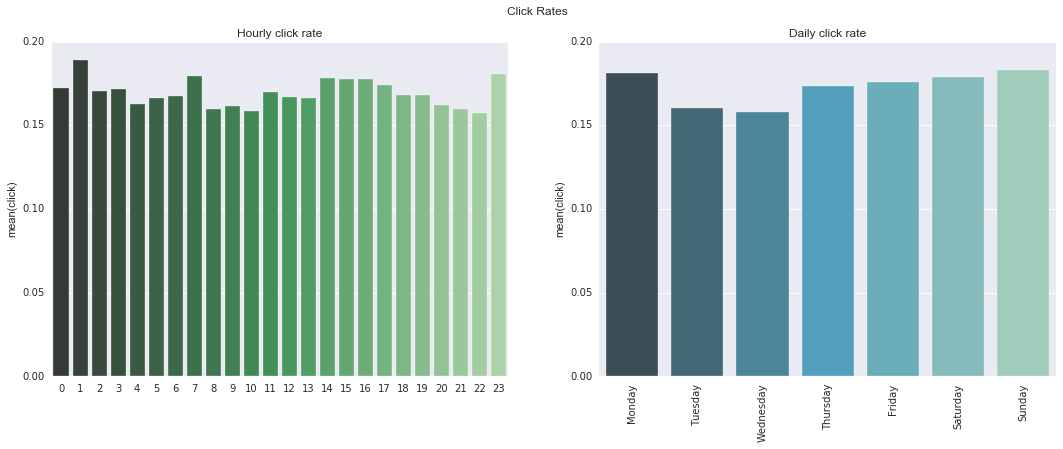

In [668]:
fig,ax= plt.subplots(figsize=(18,6),ncols=2,nrows=1)
sns.set(font_scale=1)
sns.barplot(x=range(0,24),y=rate,palette="Greens_d",ax=ax[0])
sns.barplot(x=range(0,7),y=ratedaily,palette="GnBu_d",ax=ax[1])
ax[0].set_title("Hourly click rate")
ax[1].set_title("Daily click rate")
plt.suptitle("Click Rates")
plt.xticks(range(7),weekdays,rotation=90)

### OBSERVATIONS
There is spike on at 1 am and 23. So we if we have a overall look it may be noticed that people may like shopping late hours.

Sunday has the highest click rate of 18.3% which makes sense as people usually prefer shopping more on holidays, but Monday has the second highest click rate of 18.1%. Perhahs it could be due to people shopping late nights on sundays which gives impression of people shopping on mondays.

In order to have a clearer understanding lets see at the click rates for each day

In [676]:
## Grouped data by day and hour and found total clicks for each day and each hour
shourandday=sampletrain.groupby(['hour','weekday']).sum().reset_index()

In [677]:
shourandday.head(2)

,hour,weekday,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day
0,0,0,105,638294,146,616,184,12470600,202408,40390,1393139,1258,158020,39539798,50064,17145
1,0,1,338,1996019,457,2059,466,35693843,632800,118114,3958384,2053,316048,83679292,152114,47299


In [678]:
## Grouped data by day and hour and found total activity for each day and each hour
hourlytemp=sampletrain.groupby(['hour','weekday']).count().reset_index()[['click','hour','weekday']]
hourlytemp.columns=[u'clickhourly', u'hour',u'weekday']
## Merged data with click count data to have data frame containing click and over all activity on hourly and daily baisis
shourandday1=hourlytemp.merge(shourandday,on=['hour','weekday'])
##Calculated rate by dividing hourly click by hourly overall activity
shourandday1['hourlyrate'] = shourandday1.click/shourandday1.clickhourly

### 2.3b Visualizing click rate for hour on each day of the week

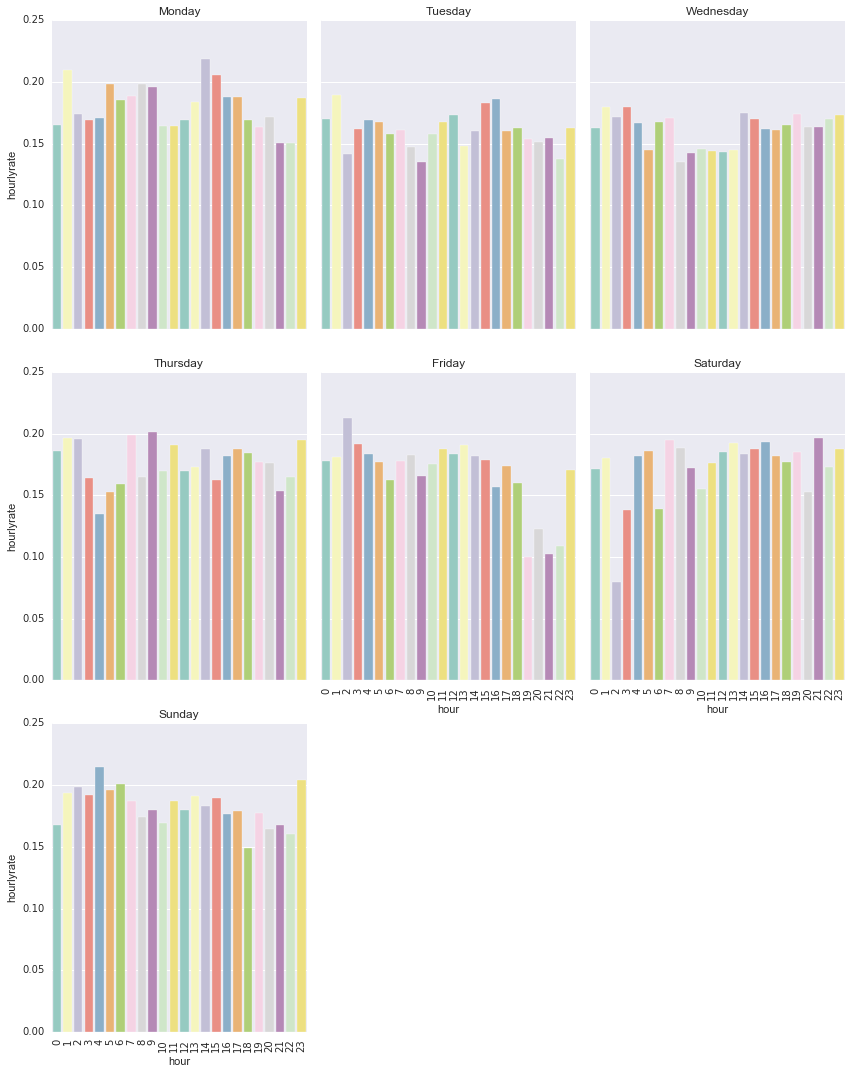

In [685]:
g = sns.factorplot(x="hour", y="hourlyrate",col='weekday', col_wrap=3,
                    data=shourandday1,kind="bar", size=5, aspect=.8,palette='Set3')
g.set_xticklabels(rotation=90)
for ax, title in zip(g.axes.flat, weekdays):
    ax.set_title(title)


### Observation:

Click rate is exceeding 20% on Monday at 1am,2pm and 3pm, Friday at 2 am and Sunday at 4am and 11:pm. Inital assumption was that people prefer shopping during the day on weekdays and late nights on the weekends. Data suggests people shopped late on thursdays seen at 1am spike on friday plot. lot of people also visisted website late night seen on sunday's spike at 4am and 6am. People may stay up late night on saturday's due to holiday next day as it appears unlikely to wake up early at 4am on weekend to visit a shopping website. Late night shopping trends could also be need on sunday's through spike at 1am on Monday's plot.

# 3. Device type Visualization

### 3.1 Device type click count

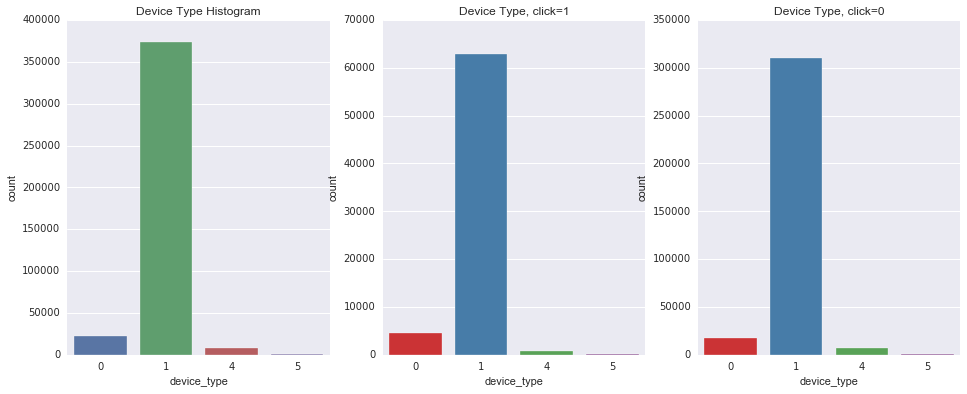

In [821]:
fig,axes = subplots(nrows=1,ncols=3)
sns.countplot('device_type', data=sampletrain,ax=axes[0])
axes[0].set_title("Device Type Histogram")
sns.countplot("device_type",data=sampletrain[sampletrain.click==1],palette='Set1',ax=axes[1])
axes[1].set_title("Device Type, click=1")
sns.countplot("device_type",data=sampletrain[sampletrain.click==0],palette='Set1',ax=axes[2])
axes[2].set_title("Device Type, click=0")

### 3.2  Click rate for devices

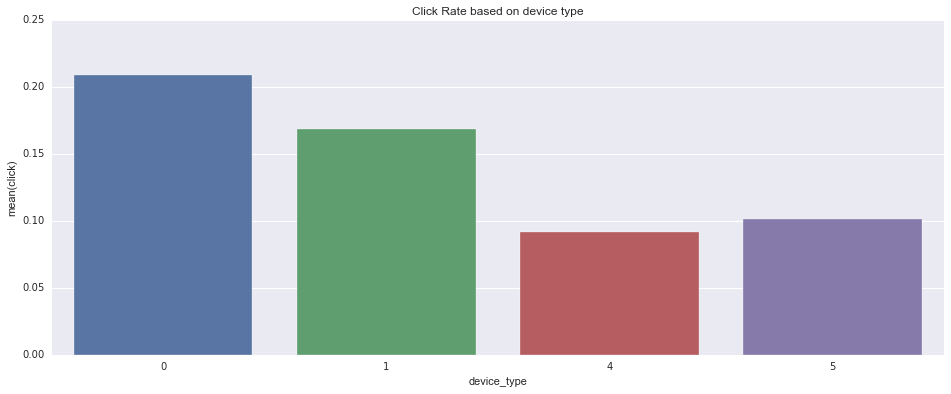

In [822]:
device_df=sampletrain.groupby(['device_type']).sum()[['click']]/sampletrain.groupby(['device_type']).count()[['click']]
device_df=device_df.reset_index()
g = sns.barplot(x='device_type',y='click',data=device_df)
plt.title("Click Rate based on device type")

### Observation:

Clearly device 1 is appeared to be the most popular device based on total click count. Althogh device 0 has higher clik rate.

# 4. Banner Position

### 4.1 Banner positon click count

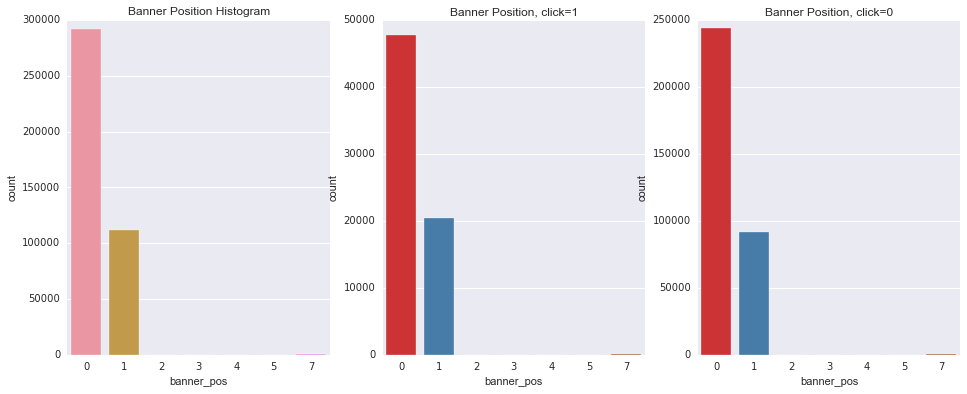

In [819]:
fig,axes = subplots(nrows=1,ncols=3)
sns.countplot('banner_pos', data=sampletrain,ax=axes[0])
axes[0].set_title("Banner Position Histogram")
sns.countplot("banner_pos",data=sampletrain[sampletrain.click==1],palette='Set1',ax=axes[1])
axes[1].set_title("Banner Position, click=1")
sns.countplot("banner_pos",data=sampletrain[sampletrain.click==0],palette='Set1',ax=axes[2])
axes[2].set_title("Banner Position, click=0")

### 4.3 Click Rate for banner Position

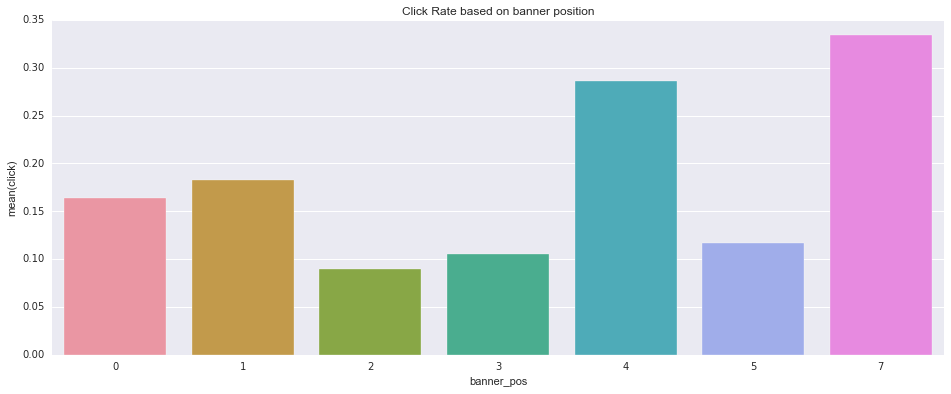

In [820]:
banner_df=sampletrain.groupby(['banner_pos']).sum()[['click']]/sampletrain.groupby(['banner_pos']).count()[['click']]
banner_df=banner_df.reset_index()
g = sns.barplot(x='banner_pos',y='click',data=banner_df)
plt.title("Click Rate based on banner position")

### Observation
Here banner position 7 appears to attract higher click rate. It is interesting to note how most people visit banner 0 more based on just count but position 7 seems to converts more vists to clicks.

# 5. App Category

### 5.1 App Category click count

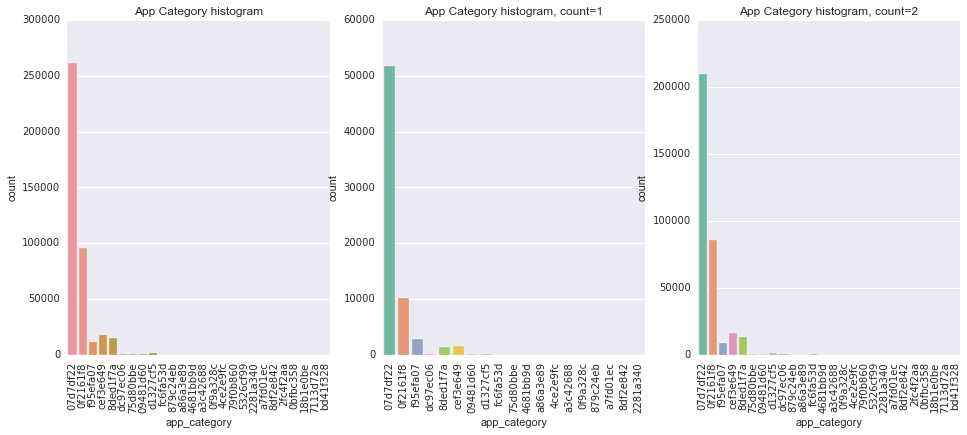

In [818]:
fig,ax=plt.subplots(ncols=3,nrows=1)
sns.countplot('app_category', data=sampletrain,ax=ax[0])
ax[0].set_title("App Category histogram")
for item in ax[0].get_xticklabels():
    item.set_rotation(90)
sns.countplot("app_category",data=sampletrain[sampletrain.click==1],palette='Set2',ax=ax[1])
ax[1].set_title("App Category histogram, count=1")
for item in ax[1].get_xticklabels():
    item.set_rotation(90)
sns.countplot("app_category",data=sampletrain[sampletrain.click==0],palette='Set2',ax=ax[2])
ax[2].set_title("App Category histogram, count=2")
for item in ax[2].get_xticklabels():
    item.set_rotation(90)

### 5.2 Click rate for App Category

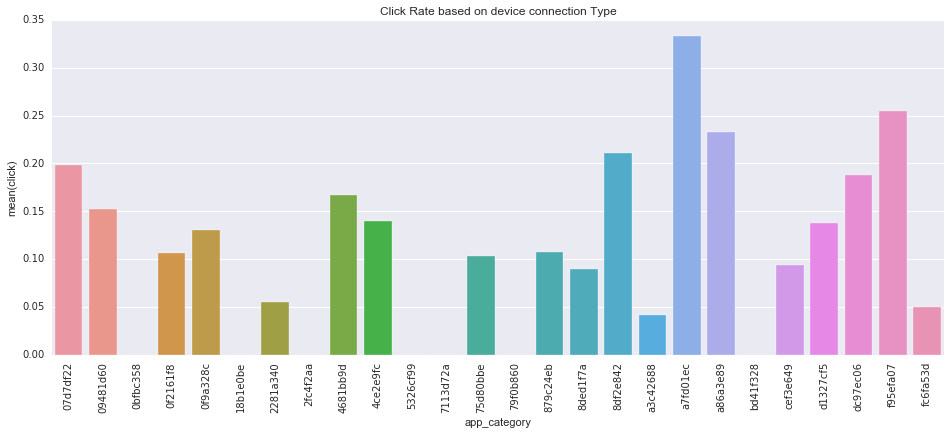

In [811]:
appcategory_df=sampletrain.groupby(['app_category']).sum()[['click']]/sampletrain.groupby(['app_category']).count()[['click']]
appcategory_df=appcategory_df.reset_index()
g = sns.barplot(x='app_category',y='click',data=appcategory_df)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.title("Click Rate based on device connection Type")

### Observations
Click rate for app a7fd01ec is highest here exceeting more than 30%. Although it is interesting to note how so many devices get to gain high click rate.  

# 6. Plotting Device Connection Type

### 6.1 Total count based on device connection type

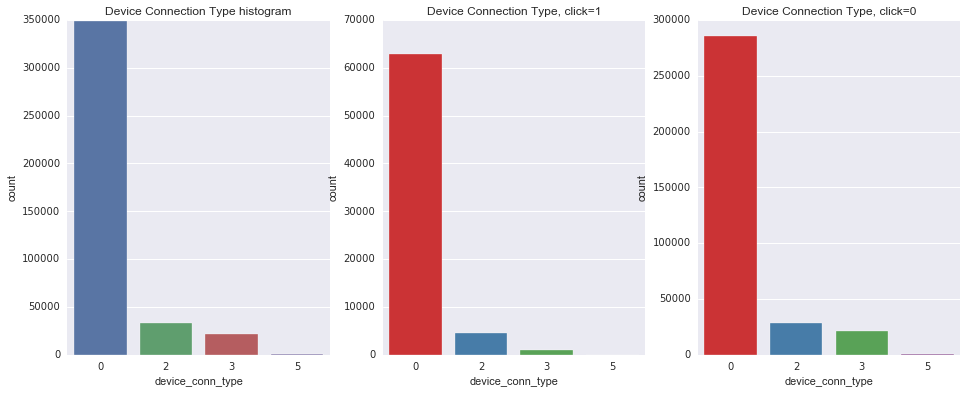

In [809]:
fig,axes = subplots(nrows=1,ncols=3)
sns.countplot('device_conn_type', data=sampletrain,ax=axes[0])
axes[0].set_title("Device Connection Type histogram")
sns.countplot("device_conn_type",data=sampletrain[sampletrain.click==1],palette='Set1',ax=axes[1])
axes[1].set_title("Device Connection Type, click=1")
sns.countplot("device_conn_type",data=sampletrain[sampletrain.click==0],palette='Set1',ax=axes[2])
axes[2].set_title("Device Connection Type, click=0")

### 6.2 Click rate based of Device Connection Type

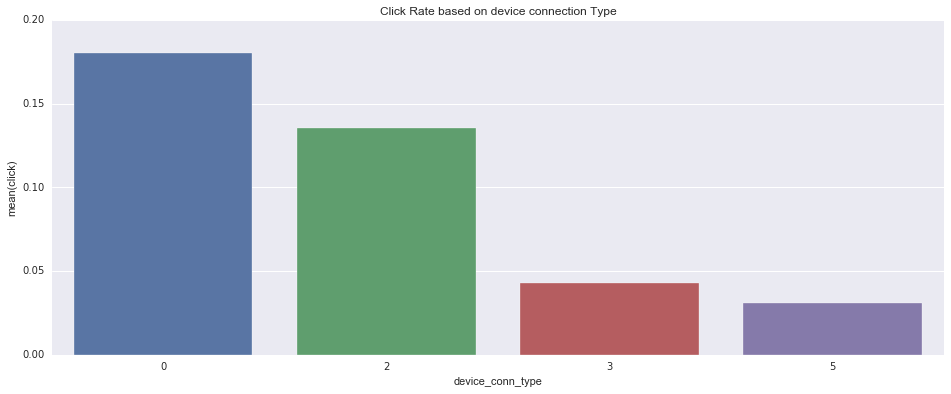

In [810]:
dev_conn=sampletrain.groupby(['device_conn_type']).sum()[['click']]/sampletrain.groupby(['device_conn_type']).count()[['click']]
dev_conn=dev_conn.reset_index()
g = sns.barplot(x='device_conn_type',y='click',data=dev_conn)
plt.title("Click Rate based on device connection Type")

Here Connection types click rate is similar to  total click count as above. It appears connection type 0 is the most popular type of connection both in terms of availibility and click conversion

# 7. Visualizing C variable

### 7.1 Click rate for variables having not too many categories

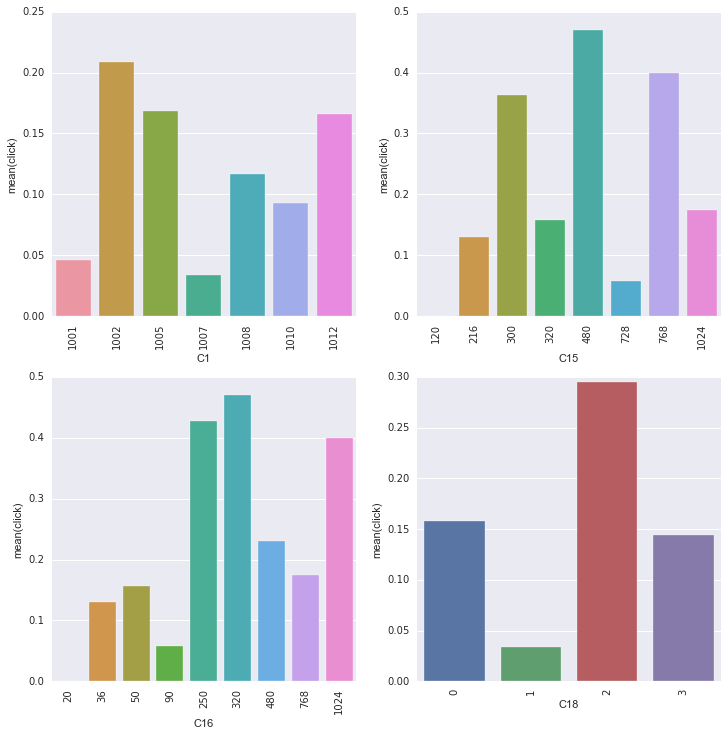

In [738]:
var=[[u'C1', u'C15'],[ u'C16',u'C18'],[u'C20']]
fig,axes = subplots(figsize=(12,12),ncols=3,nrows=2)
for m,n in zip(axes,var):
    for i,j in zip(n,m):
        dev_conn=sampletrain.groupby([''+i]).sum()[['click']]/sampletrain.groupby([''+i]).count()[['click']]
        dev_conn=dev_conn.reset_index()
        g=sns.barplot(x=''+i,y='click',data=dev_conn,ax=j)
        for item in g.get_xticklabels():
            item.set_rotation(90)

### Observation

All C variables with not too many categories are visualized above.


In [753]:
## Normalizing C feature data with high number of categorical values 
from sklearn import preprocessing
df=sampletrain[[u'C14', u'C17', u'C18',u'C19',u'C20',u'C21']]
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns=[u'C14', u'C17', u'C18',u'C19',u'C20',u'C21']

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### 7.2 Visualizing Linear regression plot for high number for "C" Categorical Values 

Visualizing to see in strong relation between click rates and these features be seen on univariate regression model

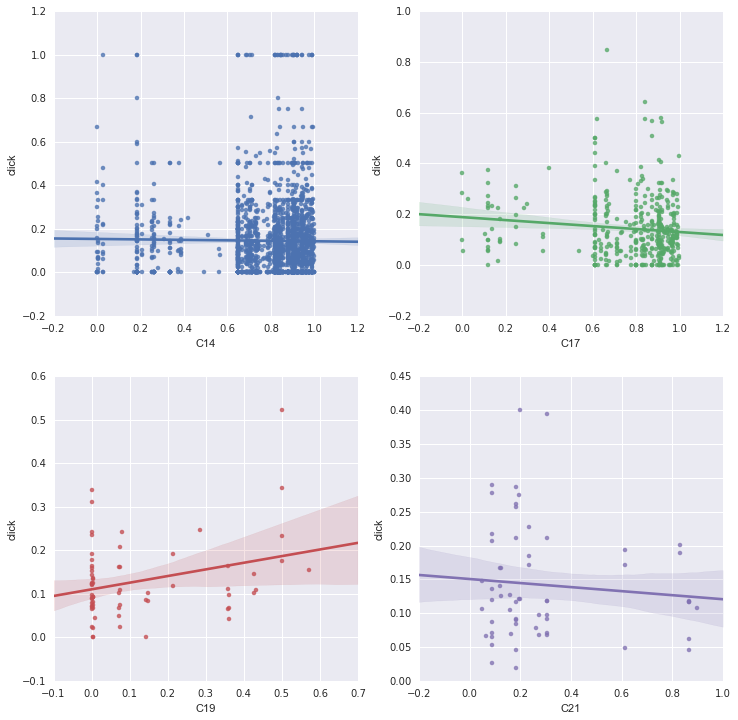

In [763]:
var1=[[u'C14', u'C17'],[u'C19',u'C21']]
fig,axes = subplots(figsize=(12,12),ncols=2,nrows=2)
for m,n in zip(axes,var1):
    for i,j in zip(n,m):
        Cscatter=sampletrain.groupby([''+i]).sum()[['click']]/sampletrain.groupby([''+i]).count()[['click']]
        Cscatter=Cscatter.reset_index()
        Cscatter[''+i]=df[''+i]
        ax=sns.regplot(x=''+i,y='click',data=Cscatter,ax=j)
        for item in g.get_xticklabels():
            item.set_rotation(90)

### 7.3 Visualizing C20 

C20 is visualized seperately due to it's high variance. Data has lot of -1 values at one end and lot of values near 100,000 at other extreme end. Therefore plotting variable with all data, without -1 and with only -1

In [74]:
from scipy.stats import pearsonr

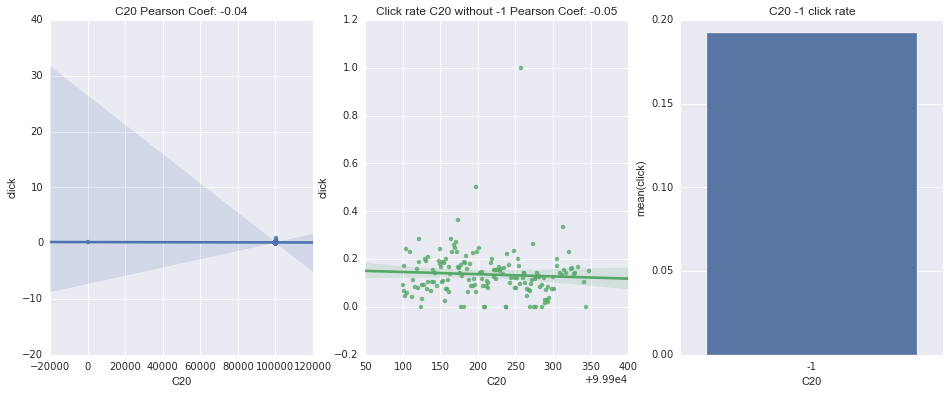

In [801]:
plt.figure(figsize(16,6))
fig,axes = subplots(ncols=3,nrows=1)
Cscatter=sampletrain.groupby(['C20']).sum()[['click']]/sampletrain.groupby(['C20']).count()[['click']]
Cscatter=Cscatter.reset_index()
axes[0]=sns.regplot(x='C20',y='click',data=Cscatter,ax=axes[0])
axes[0].set_title("C20 "+"Pearson Coef: "+ str(pearsonr(Cscatter.C20,Cscatter.click)[0])[:5])
Cscatter1=Cscatter[Cscatter.C20!=-1]
axes[1]=sns.regplot(x='C20',y='click',data=Cscatter1,ax=axes[1])
axes[1].set_title("Click rate C20 without -1 "+"Pearson Coef: "+str(pearsonr(Cscatter1.C20,Cscatter1.click)[0])[:5])
Cscatter2=Cscatter[Cscatter.C20==-1]
axes[2]=sns.barplot(x='C20',y='click',data=Cscatter2,ax=axes[2])
axes[2].set_title("C20 -1 click rate")

In [301]:
l=sampletrain[['device_type','app_category','device_conn_type','banner_pos','click','site_domain']]

In [308]:
l1=sampletrain[[u'click', u'hour', u'C1', 'C14', u'C15', u'C16', u'C17',
       u'C18', u'C19', u'C20', u'C21']]

# 7. Scatter matrix for anonymized categorical features, clicks and hour.

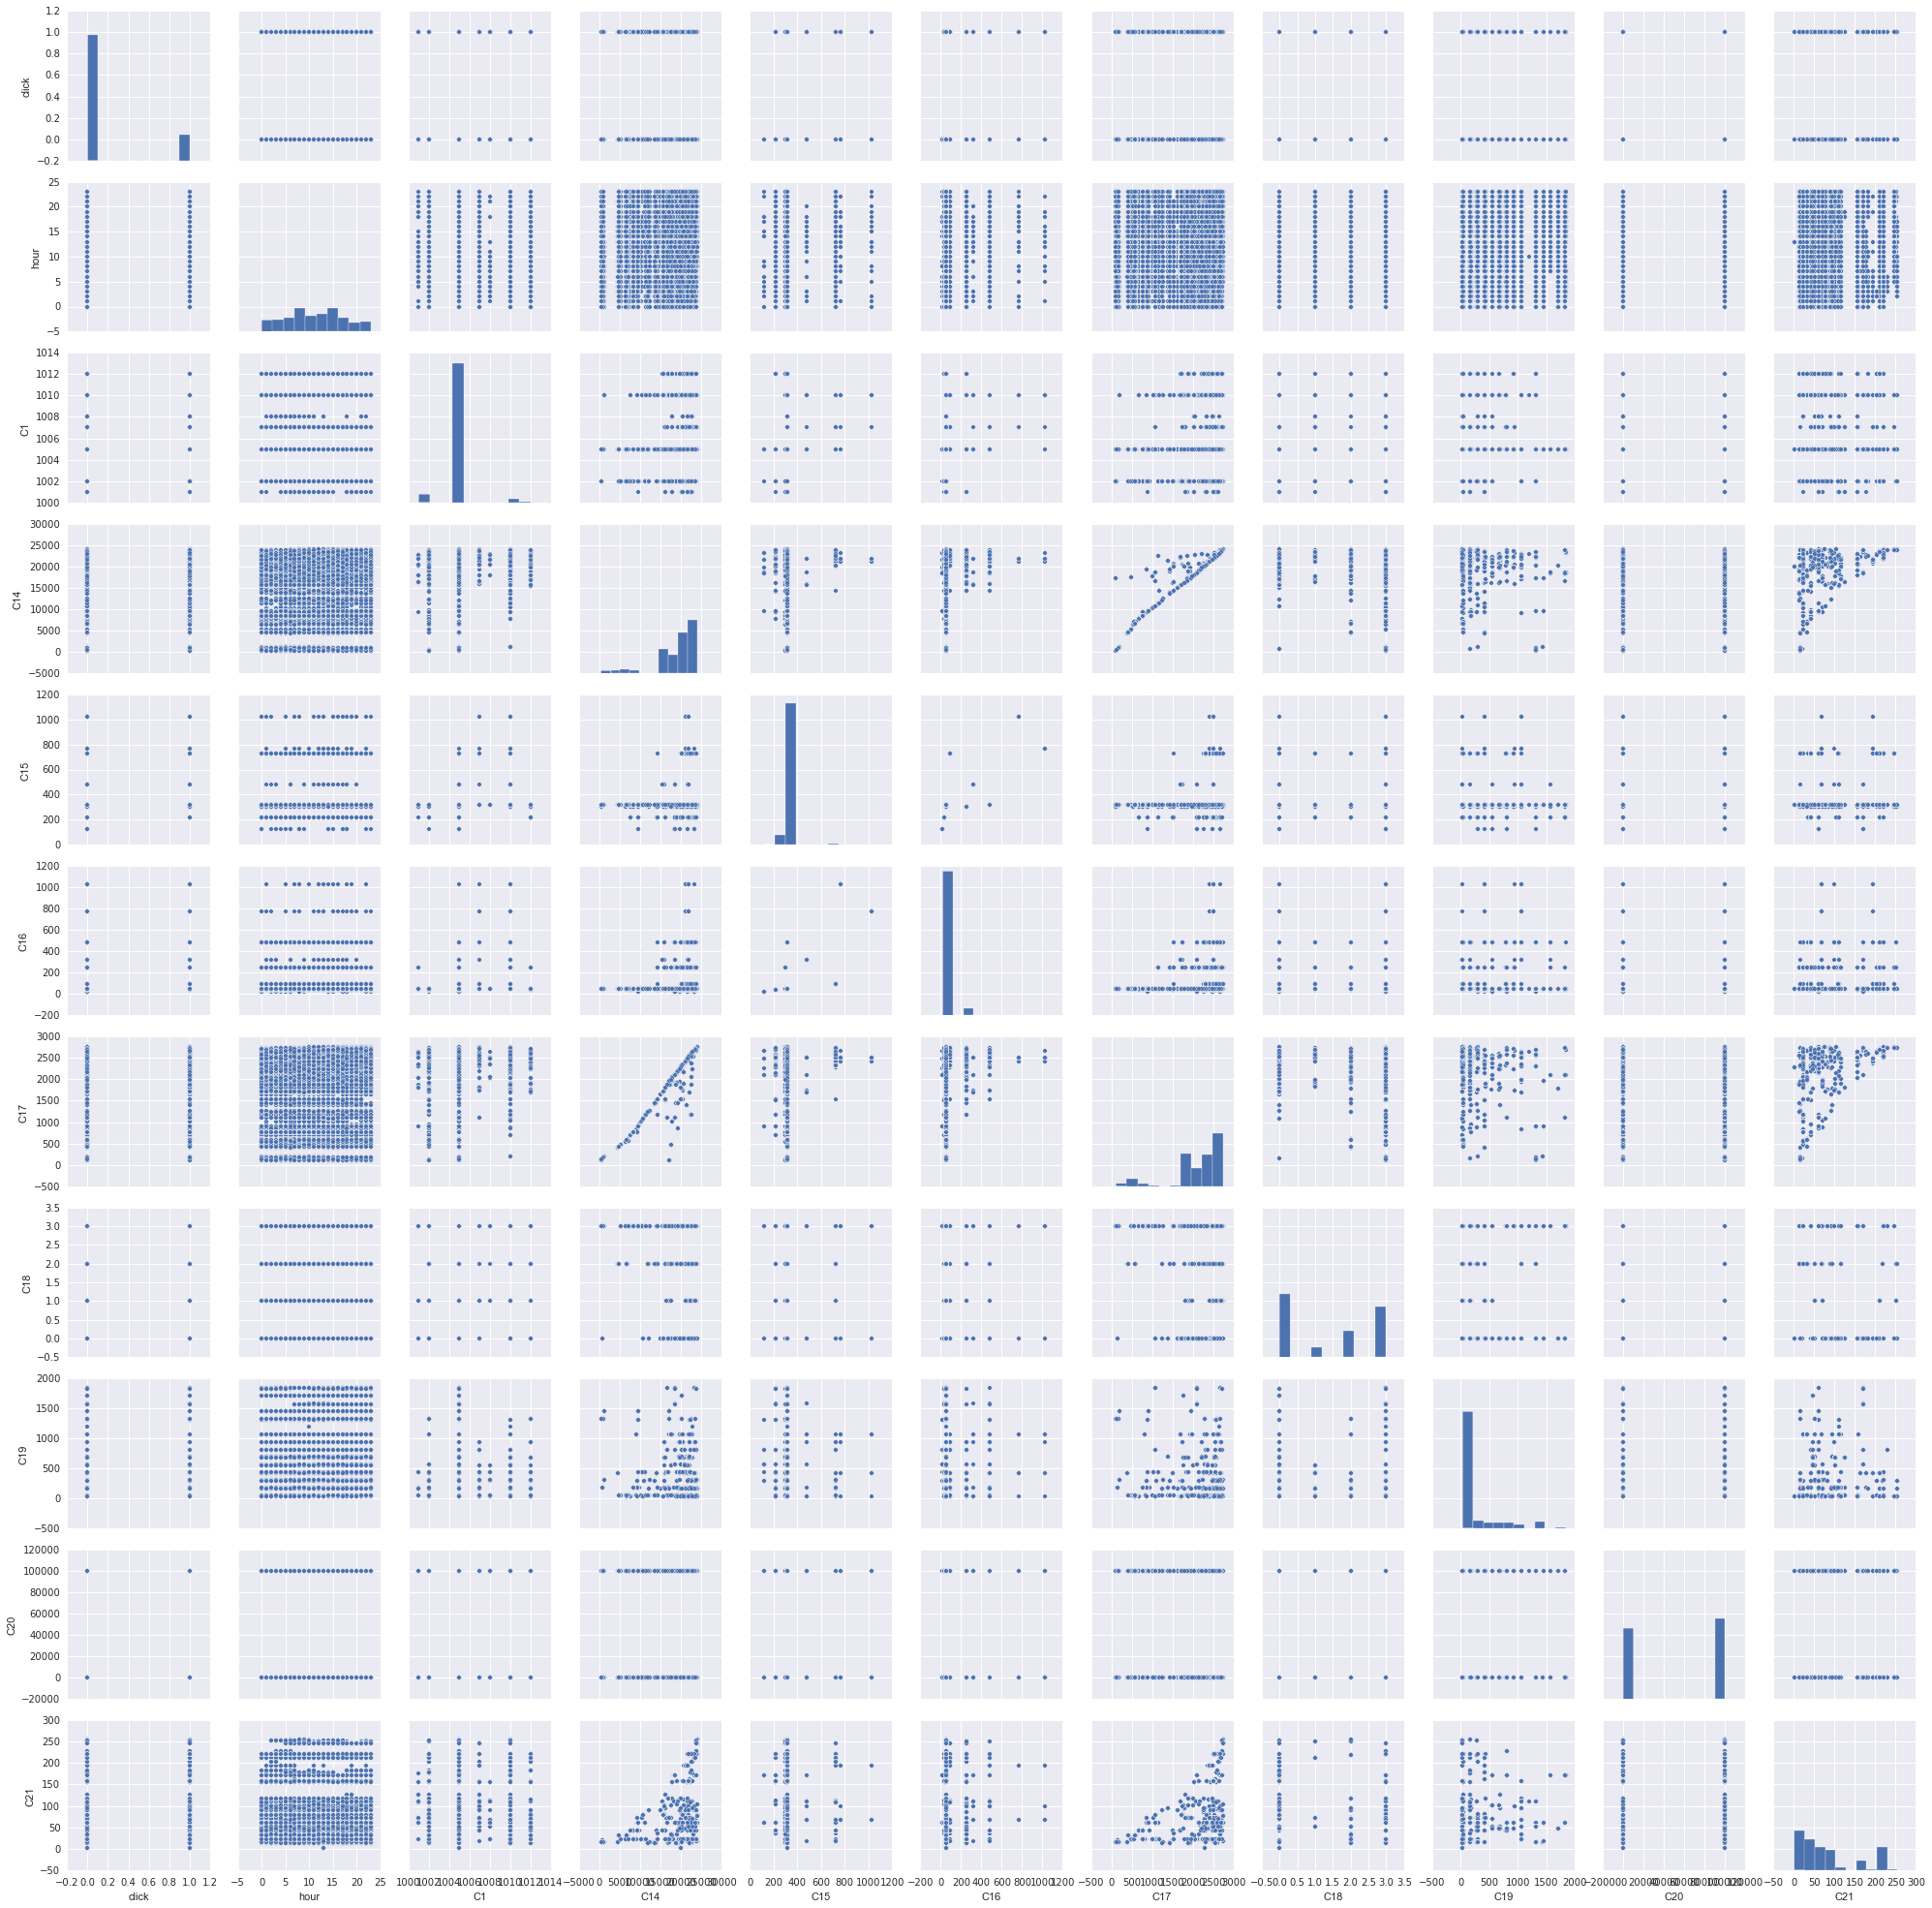

In [309]:
sns.set(font_scale=1)
sns.pairplot(l1)

### Observation:

C14 and C17 appears to be very strongly corelated. Co-orelation among the independent features usually undermines the impact of feature. Therefore, identifying and removing features which show strong co-relation could be a possible move to imporve model

In [365]:
pearsonr(l1.C14,l1.C17)

(0.97688300044894205, 0.0)

In [75]:
pearsonr(sampletrain.C1,sampletrain.device_type)

(0.89345107427614956, 0.0)

In [359]:
c = sampletrain.corr()

# 8. Correlation Matrix

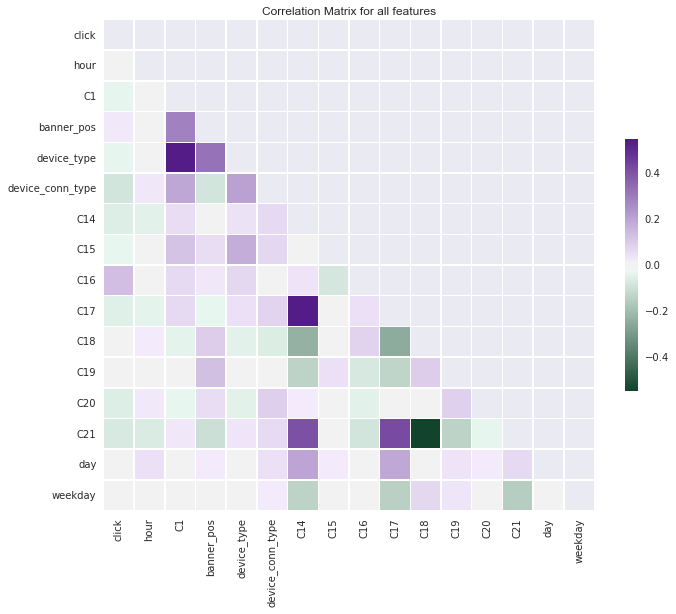

In [689]:
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(145, 280, s=85, l=25, n=7, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.xticks(rotation=90)
plt.title("Correlation Matrix for all features")

C1 and Device type coorelates strongly and as previously observed c14 and c17 are strogly corelated. Therefore, features causing coorelation would be eliminated in order to reduce effects of multicolliniarity.

There could be seen some relation between device type and banner position. Although it's hard to judge by how much one feature explains the other based on just pearson coorelation. Perhaps variation inflation factor could help in identifying the impact of coorelation.

### Logistic Regression:

In [4]:
import statsmodels.formula.api as smf
logit = smf.logit('click ~ C(banner_pos) + C(device_type)', data = sampletrain).fit() 
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.454346
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:               404290
Model:                          Logit   Df Residuals:                   404280
Method:                           MLE   Df Model:                            9
Date:                Mon, 28 Nov 2016   Pseudo R-squ.:                0.003513
Time:                        01:27:45   Log-Likelihood:            -1.8369e+05
converged:                       True   LL-Null:                   -1.8434e+05
                                        LLR p-value:                3.743e-273
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -1.3169      0.016    -80.213      0.000        -1.349    -1.285
C(

In [57]:
logit = smf.logit('click ~ C14 +C17', data = sampletrain).fit() 
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.454267
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:               404290
Model:                          Logit   Df Residuals:                   404287
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Nov 2016   Pseudo R-squ.:                0.003686
Time:                        14:30:14   Log-Likelihood:            -1.8366e+05
converged:                       True   LL-Null:                   -1.8434e+05
                                        LLR p-value:                8.301e-296
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0125      0.016    -64.718      0.000        -1.043    -0.982
C14        -6.118e-05   4.21e

### Observation:

Here we create a bi-variate model to understand impact of multicoliniarity on response variable. Also it would help understand which variable would be a  best choice if it commes to choosing one.

----------------------------------------------------------------------------------------------------------------------
# <center> <u>Model Building </u></center>

In [4]:
## At this point I believe it is better to save the sample data as csv and restart notebook, as other variables used
## in exploratory analysis would not be be needed here.

In [3]:
sampletrain=pd.read_csv('sample_data.csv')

In [5]:
for i in sampletrain.columns:
    print i, len(sampletrain[''+i].unique())

Unnamed: 0 404290
id 404290
click 2
hour 24
C1 7
banner_pos 7
site_id 2151
site_domain 2170
site_category 20
app_id 2277
app_domain 151
app_category 26
device_id 64708
device_ip 262252
device_model 4419
device_type 4
device_conn_type 4
C14 2058
C15 8
C16 9
C17 415
C18 4
C19 65
C20 163
C21 60
date 240
day 10
weekday 7


In [7]:
404290*1.0/262252

1.5416088342510257

In [ ]:
len(sampletrain.device_id.unique())

In [24]:
sample = sampletrain.copy()

# Approach 1

# 1.1 Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
## Data Processing
sample = sampletrain.copy()
dev_ipdict=pd.DataFrame(sample.device_ip.value_counts()).to_dict()['device_ip']
dev_mdldict=pd.DataFrame(sample.device_model.value_counts()).to_dict()['device_model']
dev_id=pd.DataFrame(sample.device_id.value_counts()).to_dict()['device_id']
app_iddict=pd.DataFrame(sample.app_id.value_counts()).to_dict()['app_id']

In [7]:
sample['device_ipCount']=sample.device_ip.map(lambda x:dev_ipdict[''+x])
sample['device_mdlCount']=sample.device_model.map(lambda x:dev_mdldict[''+x])

#sample['device_idCount']=sample.device_id.map(lambda x:dev_id[''+x])
#sample['app_idCount']=sample.app_id.map(lambda x:app_iddict[''+x])

## Selecting only features with less than 50 categorical values and creating their dummy variable
dftrain1=pd.get_dummies(sample[['site_category','app_category']])
dfmodeltemp=sample.select_dtypes(include=['int'])
## concatenating integer and dummy variable to have final training set. 
dfmodel=pd.concat([dftrain1,dfmodeltemp],1)
sample=dfmodel.drop('Unnamed: 0',1)

In [8]:
#Using cluster as a feature
#sm=sample[['C14','C17','device_ipCount','device_mdlCount','device_idCount','app_idCount']].as_matrix()
#from sklearn.cluster import KMeans
#model1=KMeans(n_clusters=1000).fit(sm)


In [10]:
##taking training data for 9 days and testing 10th
strain = sample[sample.day!=30].drop(['click'],1)
ytrainlabel = sample[sample.day!=30]['click']
svalid = sample[sample.day==30].drop(['click'],1)
ytestlabel = sample[sample.day==30]['click']

In [11]:
#strain[[u'C1',u'C15',u'C16',u'C18']]=strain[[u'C1',u'C15',u'C16',u'C18']].astype(str)

In [12]:
strain.shape

(361908, 63)

In [13]:
lmodel=LogisticRegression(n_jobs=-1).fit(strain,ytrainlabel)
predictionsvalid=lmodel.predict(svalid)

In [14]:
accuracy=lmodel.score(svalid,ytestlabel)
print "Accuracy score is: ",accuracy

Accuracy score is:  0.831626633948


In [16]:
pt=pd.DataFrame({'true':ytestlabel,'predicted':predictionsvalid})
pt[pt.true==pt.predicted]['predicted'].value_counts()

0    35223
1       23
Name: predicted, dtype: int64

In [17]:
pt=pd.DataFrame({'true':ytestlabel,'predicted':predictionsvalid})
true_positives = pt[pt.true==pt.predicted]['predicted'].value_counts()[1]
true_negatives = pt[pt.true==pt.predicted]['predicted'].value_counts()[0]
false_positive = pt[(pt.predicted==1) & (pt.true==0)].shape[0]
false_negatives = pt[(pt.predicted==0) & (pt.true==1)].shape[0]

In [18]:
precision = true_positives*1.0/(true_positives+false_positive)
recall = true_positives*1.0/(true_positives+false_negatives)
print 'precision is: ',precision 
print 'recall is: ', recall


precision is:  0.310810810811
recall is:  0.00323579065841


In [22]:
lm_predictions = lmodel.predict_proba(svalid)[:, 1]
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(ytestlabel, lm_predictions))

0.602023615734


In [22]:
#Observing if top categories covers enough data such that we could ignore other non-frequent categories

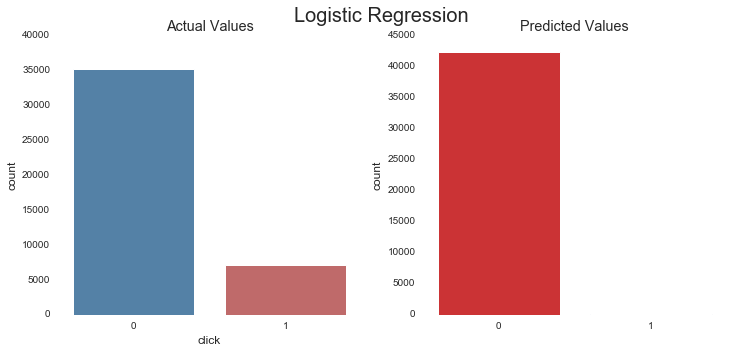

In [398]:
fig,ax= subplots(figsize=(12,5),nrows=1,ncols=2)
sns.countplot(ytestlabel,ax=ax[0])
sns.countplot(predictionsvalid,palette='Set1',ax=ax[1])
ax[0].set_title("Actual Values")
ax[1].set_title("Predicted Values")
plt.suptitle("Logistic Regression",fontsize=20)

In [203]:
o=sample[['site_domain','app_domain','device_id','device_model']]
for i in o.columns:
    category_occyopancy=sample[''+i].value_counts()[:50].sum()*1.0/sample.shape[0]
    val_ratio=50.0/len(sample[''+i].unique())
    print category_occyopancy*100, "of total value is covered by",val_ratio*100,"% of category in", i

print 


89.8142422518 of total value is covered by 2.30414746544 % of category in site_domain
99.9361844221 of total value is covered by 33.1125827815 % of category in app_domain
82.9132553365 of total value is covered by 0.0772701984299 % of category in device_id
51.998318039 of total value is covered by 1.13147770989 % of category in device_model



# 1.2. Random Forest

Testing Random Forest, as it identifies categories in the features without requiring the need to 'dumify' it

Tested and results show that hash of device ip and device model provides better result at rf model than using frequency count of catogaries as replacement.

In [9]:
sample=sampletrain.copy()

In [10]:
##Data Processing
#sample['device_ipHash']= sample['device_ip'].apply(lambda x:hash(x))
sample['device_mdlHash']= sample['device_model'].apply(lambda x:hash(x))
sample['device_idlHash']= sample['device_id'].apply(lambda x:hash(x))
sample['app_idlHash']= sample['app_id'].apply(lambda x:hash(x))
sample['site_idlHash']= sample['site_id'].apply(lambda x:hash(x))
#sample['site_domainlHash']= sample['site_domain'].apply(lambda x:hash(x))
#sample['add_domainlHash']= sample['app_domain'].apply(lambda x:hash(x))

site_domaindict=pd.DataFrame(sample.site_domain.value_counts()).to_dict()['site_domain']
app_domaindict=pd.DataFrame(sample.app_domain.value_counts()).to_dict()['app_domain']
dev_ipdict=pd.DataFrame(sample.device_ip.value_counts()).to_dict()['device_ip']

sample['site_domain_Count']=sample.site_domain.map(lambda x:site_domaindict[''+x])
sample['app_domain_Count']=sample.app_domain.map(lambda x:app_domaindict[''+x])
sample['dev_ip']=sample.device_ip.map(lambda x:dev_ipdict[''+x])
sample=sample.drop(['id','date','Unnamed: 0','C14'],1)
s_temp=sample.select_dtypes(include=['int'])
s_temp1=sample[['site_category','app_category']]
s_dummy=pd.get_dummies(s_temp1)
dfmodel=pd.concat([s_dummy,s_temp],1)
print dfmodel.shape
##Splitting data to test and train
strain = dfmodel[dfmodel.day!=30].drop(['click'],1)
ytrainlabel = dfmodel[dfmodel.day!=30]['click']
svalid = dfmodel[dfmodel.day==30].drop(['click'],1)
ytestlabel = dfmodel[dfmodel.day==30]['click']

(404290, 68)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [12]:
num_trees = 500
##for max precision
#rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1,max_depth=12,min_samples_split=10
##verbose=1,oob_score = True)

##for slighly better balance between recall and precision
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1,max_depth=25,
                            min_samples_split=10,verbose=1,oob_score = False)
rf.fit(X=strain, y=ytrainlabel)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [13]:
rf_predictions = rf.predict_proba(svalid)[:, 1]
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(ytestlabel, rf_predictions))

# get accuracy (predict the class)
rf_predictions_class = rf.predict(svalid)
print (accuracy_score(ytestlabel, rf_predictions_class, normalize=True))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.6s finished


0.713786594337


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.4s finished


0.835472606295


In [14]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall,fscore,support=precision_recall_fscore_support(ytestlabel, rf_predictions_class,average='macro')

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [15]:
print 'precision is: ',precision 
print 'recall is: ', recall
print 'f-score is: ', fscore

precision is:  0.576791808874
recall is:  0.0713280810355
f-score is:  0.126956303994


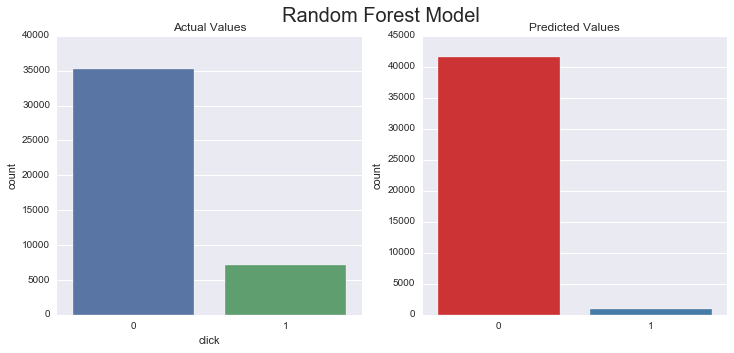

In [513]:
fig,ax= subplots(figsize=(12,5),nrows=1,ncols=2)
sns.countplot(ytestlabel,ax=ax[0])
sns.countplot(rf_predictions_class,palette='Set1',ax=ax[1])
ax[0].set_title("Actual Values")
ax[1].set_title("Predicted Values")
plt.suptitle("Random Forest Model",fontsize=20)

### Observation 

Accuracy is important metric but it doesn't share the complete picture for the model prediction. Since there is approximately 17% click rate which means if model detected only true negatives and no true positives, yet accuracy would be high with apporoximately 83%.  Therefore Precision, Recall and AUC score provides with better picture since they talk about relevet information. Here precision is 56.89% suggesting not too many false positive values. (Type 1 Error) i.e non-clicks being predicted as valid click. On the other hand recall shares high false negative rate (Type 2 Error) i.e clicks being identified as non-clicks. 

For this problem, information about both false positive and false negative is important as they provide a better model and prediction capability of clicks, which could be strategised to increase sales. If we care only about clicks then recall is important, but higher false positive would over estimate the click rate. Hence, ideally there should be  balance for a robust model.

In [16]:
#Feature Importance
importances = rf.feature_importances_

In [17]:
featre_imp=pd.DataFrame([strain.columns,importances]).T
featre_imp.columns=['columns','Feature Importance']


## Visualizing Gini Feature Importance for Random forest

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 67 Text xticklabel objects>)

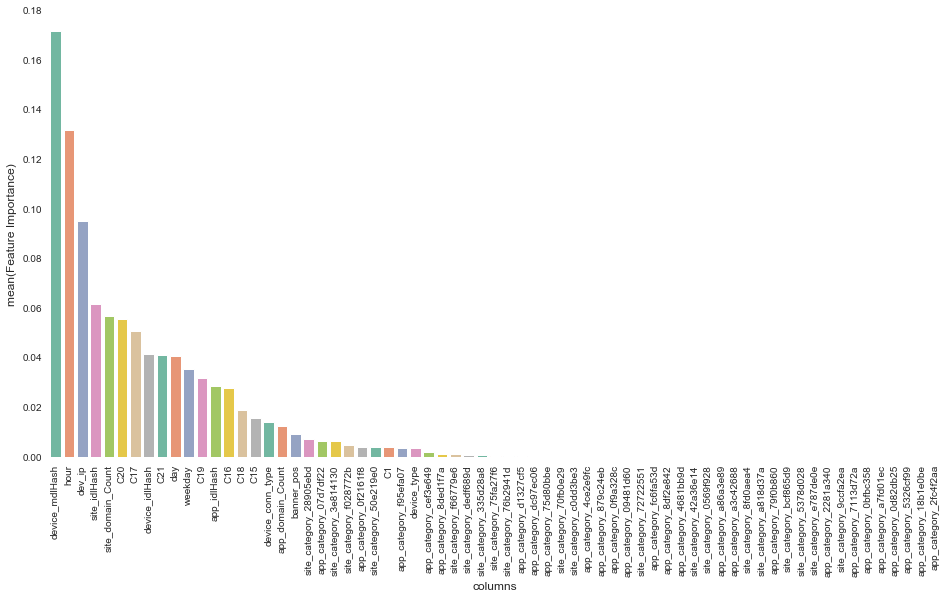

In [18]:
featre_imp=featre_imp.sort('Feature Importance',ascending=False)
plt.figure(figsize=(16,8))
sns.barplot(x='columns',y='Feature Importance',data=featre_imp,palette='Set2')
plt.xticks(rotation=90)

Hash value of deviceip, device model are the top features influencing the click rate followed by hour. Hence it suggest the importance of feature engineering and their effect on the model. However app category and site category doesn't influence response variable much

# Approach 2

Considering a day to see if model could be build based on individual days of the week

In [420]:
## set days below
def feature_hashing_daySelector(x):
    sample = sampletrain.copy()
    sample2 = sample[sample.weekday==x].drop(['Unnamed: 0','id','date'],1)
    sample2=sample2.reset_index().drop('index',1)
    sample2['device_ipHash']= sample2['device_ip'].apply(lambda x:hash(x))
    sample2['device_mdlHash']= sample2['device_model'].apply(lambda x:hash(x))
    sample2['device_idlHash']= sample2['device_id'].apply(lambda x:hash(x))
    sample2['app_idlHash']= sample2['app_id'].apply(lambda x:hash(x))
    s1=sample2.select_dtypes(include=['int'])
    s2=sample2[['site_category','app_category']]
    s2=pd.get_dummies(s2)
    sample3=pd.concat([s1,s2],1)
    return sample3

In [421]:
### Running 5 fold cross validation for random forest model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
week=range(7)
prec={}
rec={}
accuracy={}
roc={}
for days in week:
    data=feature_hashing_daySelector(days)
    X=data.drop('click',1)
    Y=data.click
    kf = KFold(len(X),5,shuffle=True)
    a_total=0
    r_total=0
    p_total=0
    roc_total=0
    for train_indices, test_indices in kf:
        
        # Get the dataset; this is the way to access values in a pandas DataFrame
        train_X = X.ix[train_indices, :] 
        test_X = X.ix[test_indices, :] 
        train_Y = Y[train_indices]
        test_Y = Y[test_indices]
        #print train_indices, test_indices
        num_trees = 500
        rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, min_samples_split=5,
                                    verbose=0,max_depth=12,oob_score = True)
        rf.fit(X=train_X, y=train_Y)
        rf_predictions = rf.predict_proba(test_X)[:, 1]
        roc_total+=roc_auc_score(test_Y, rf_predictions)
        rf_predictions_class = rf.predict(test_X)
        a_total+=accuracy_score(test_Y, rf_predictions_class, normalize=True)
        precision,recall,fscore,support=precision_recall_fscore_support(test_Y, rf_predictions_class,average='macro')
        p_total+=precision
        r_total+=recall
    roc[days]=roc_total/5
    prec[days]=p_total/5
    rec[days]=r_total/5
    accuracy[days]=a_total/5
    
    

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class perform

In [422]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
score_rf=pd.DataFrame([accuracy,roc,prec,rec]).T
score_rf.columns=['Accuracy','Roc','Precision','Recall']

In [423]:
score_rf['Weekdays']=weekdays

In [431]:
score_rf

,Accuracy,Roc,Precision,Recall,Weekdays
0,0.816959,0.709057,0.586672,0.053427,Monday
1,0.839909,0.725896,0.577109,0.047951,Tuesday
2,0.845512,0.717015,0.625853,0.041739,Wednesday
3,0.829448,0.702946,0.627267,0.044700,Thursday
4,0.824899,0.702009,0.538393,0.049021,Friday
5,0.818939,0.712136,0.521894,0.052938,Saturday
6,0.819052,0.706280,0.564873,0.059656,Sunday


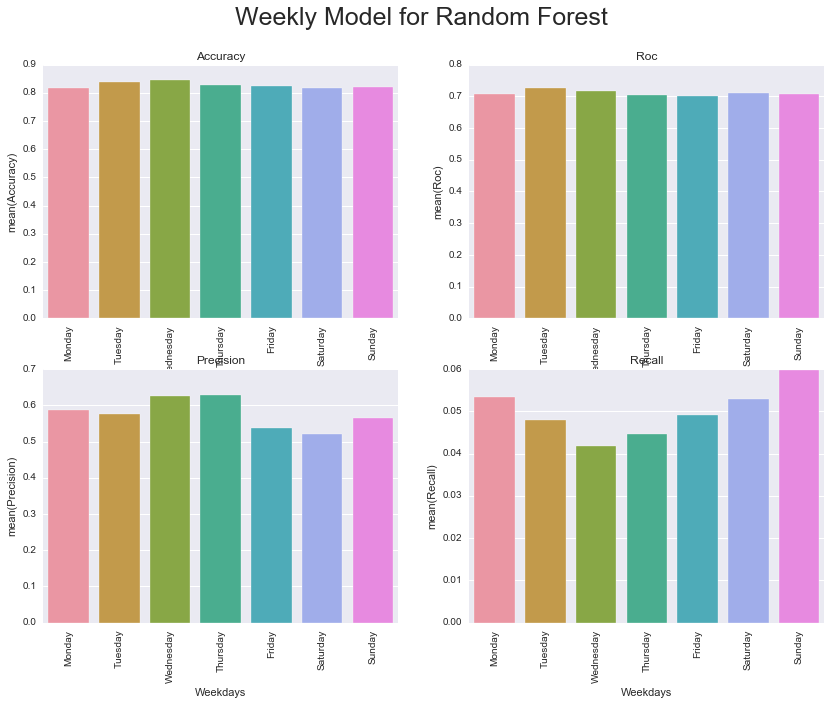

In [429]:
fig,ax=subplots(figsize=(14,10),nrows=2,ncols=2)
sns.barplot('Weekdays','Accuracy',data=score_rf, ax=ax[0][0])
sns.barplot('Weekdays','Roc',data=score_rf,ax=ax[0][1])
sns.barplot('Weekdays','Precision',data=score_rf, ax=ax[1][0])
sns.barplot('Weekdays','Recall',data=score_rf, ax=ax[1][1])
for i in range(2):
    for j in range(2):
        for item in ax[i][j].get_xticklabels():
            item.set_rotation(90)
ax[0][0].set_title("Accuracy")
ax[0][1].set_title("Roc")
ax[1][0].set_title("Precision")
ax[1][1].set_title("Recall")
plt.suptitle("Weekly Model for Random Forest",fontsize=25)

Using max depth of 12 and min split trees 5 boosts the precision, accuracy and ROC of the model. However recall is still low by reaching max of 6 percent on sundays. Highest precision could be seen aboue on Wednesday and Thurday exceeding 60%. This suggests false positivs are not very high. Error relating to non click(0) being detected as clicks(1) are low. 

This model might be slightly better than the random forest model developed using apporach 1 on certain days. But generally it gives approximately similar results. Perhaps this model would have performed better, if data on more weeks could be availed for training.

# checking accuracy of other classification methods 

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

names = [ "LogisticRegression","NaiveBayes"]
clf1 = LogisticRegression(n_jobs=-1)
#clf2 = SVC(kernel="linear")
#clf3 = SVC(kernel="rbf",gamma=0.001)
clf4 = GaussianNB()
for clf, label in zip([clf1, clf4], names):
    scores = cross_val_score(clf, dfmodel.drop('click',1), dfmodel.click, cv=10, scoring='accuracy')
    print("Mean accuracy: %0.2f Std deviation is (+/- %0.2f) for model [%s] " % (scores.mean(), scores.std(), label ))

Mean accuracy: 0.79 Std deviation is (+/- 0.00) for model [LogisticRegression] 
Mean accuracy: 0.83 Std deviation is (+/- 0.00) for model [NaiveBayes] 


In [381]:
from sklearn.naive_bayes import GaussianNB
nb= GaussianNB().fit(X=strain, y=ytrainlabel)
nb_predictions = nb.predict_proba(svalid)[:, 1]
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(ytestlabel, nb_predictions))

# get accuracy (predict the class)
nb_predictions_class = nb.predict(svalid)
print (accuracy_score(ytestlabel, nb_predictions_class, normalize=True))

0.600064018881
0.832287291775
